In [ ]:
### START CODE HERE ###
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from PIL import Image
import os

from torch.utils.data import DataLoader, Dataset, Subset, random_split
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
### END CODE HERE ###

# **Custom Pretrained Model**

In [ ]:
### START CODE HERE ###
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
### END CODE HERE ###

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 60.7MB/s]


In [ ]:
### START CODE HERE ###
class customVGG16(nn.Module):

    def __init__(self, input_size=(3, 224, 224), num_classes=10):
        super(customVGG16, self).__init__()

        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        self.vgg16.flatten = nn.Flatten()

        for param in self.vgg16.features.parameters():
            param.requires_grad = False

        for param in self.vgg16.classifier.parameters():
            param.requires_grad = False

        self.vgg16.classifier[6] = nn.Linear(
            self.vgg16.classifier[-1].in_features, num_classes)
        self.vgg16.classifier[6].requires_grad = True

    def forward(self, x):
        x = self.vgg16.features(x)
        x = self.vgg16.avgpool(x)
        x = self.vgg16.flatten(x)
        x = self.vgg16.classifier(x)
        return F.log_softmax(x, dim=1)
### END CODE HERE ###

In [ ]:
dummy_input = torch.zeros(32, *(3, 224, 224))

In [ ]:
VGG16 = customVGG16()
VGG16(dummy_input).shape

torch.Size([32, 10])

# **Prepare dataset & daraloader**

In [ ]:
### START CODE HERE ###
!curl -L -o test.zip https://raw.githubusercontent.com/shokku14/flies/main/test.zip
!unzip -o test.zip
!curl -L -o data.zip https://raw.githubusercontent.com/shokku14/flies/main/data.zip
!unzip -o data.zip
### END CODE HERE ###

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1528k  100 1528k    0     0  4587k      0 --:--:-- --:--:-- --:--:-- 4577k
Archive:  test.zip
   creating: test/submission/
  inflating: test/submission/image_0.png  
  inflating: test/submission/image_1.png  
  inflating: test/submission/image_10.png  
  inflating: test/submission/image_100.png  
  inflating: test/submission/image_101.png  
  inflating: test/submission/image_102.png  
  inflating: test/submission/image_103.png  
  inflating: test/submission/image_104.png  
  inflating: test/submission/image_105.png  
  inflating: test/submission/image_106.png  
  inflating: test/submission/image_107.png  
  inflating: test/submission/image_108.png  
  inflating: test/submission/image_109.png  
  inflating: test/submission/image_11.png  
  inflating: test/submission/image_110.png  
  inflating: test/submission/image_111.png  


In [ ]:
### START CODE HERE ###
en_path = "/content/data/data/data/eng-handwritten-dataset"
th_path = "/content/data/data/data/thai-handwritten-dataset"
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
class ReverseIntensity:

    def __init__(self, threshold=150):
        self.threshold = threshold

    def __call__(self, image):

        if isinstance(image, Image.Image):
            image_np = np.array(image)
        elif isinstance(image, np.ndarray):
            image_np = image
        else:
            raise TypeError(
                "Unsupported type. Expected PIL Image or numpy array.")

        if np.mean(image_np) > self.threshold:
            reversed_image = 255 - image_np
            return Image.fromarray(reversed_image)
        else:
            return image
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
class MultiLanguageHandwrittenDataset(Dataset):

    def __init__(self, root_dirs, languages, transforms=None):
        self.root_dirs = root_dirs
        self.languages = languages
        self.transform = transforms
        self.samples = []

        for root_dir, language in zip(self.root_dirs, self.languages):
            for subdir in os.scandir(root_dir):
                if subdir.is_dir():
                    label = int(subdir.name)
                    for file in os.scandir(subdir.path):
                        if file.is_file():
                            self.samples.append((file.path, label, language))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, label, language = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label, language

### END CODE HERE ###

In [ ]:
### START CODE HERE ###
root_dirs = [
    "/content/data/data/data/eng-handwritten-dataset",
    "/content/data/data/data/thai-handwritten-dataset"
]
languages = [0, 1]

transform = transforms.Compose([
    transforms.Grayscale(),
    ReverseIntensity(threshold=100),
    transforms.RandomAffine(degrees=(-27.5,27.5),
                            translate=(0.05, 0.05),
                            scale=(0.4, 1.2),
                            shear=10),
    transforms.Pad(15, padding_mode='constant', fill=0),
    transforms.RandomResizedCrop(size=224, scale=(0.746, 1.0)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
])

dataset = MultiLanguageHandwrittenDataset(root_dirs=root_dirs,
                                          languages=languages,
                                          transforms=transform)
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
image, label, language = next(iter(dataset))

language_labels = ['English','Thai']
image.shape, label, language_labels[language]
### END CODE HERE ###

(torch.Size([3, 224, 224]), 3, 'English')

In [ ]:
### START CODE HERE ###
def load_data(reverse=False, normalize=False, batch_size=32):
    root_dirs = [
        "/content/data/data/data/eng-handwritten-dataset",
        "/content/data/data/data/thai-handwritten-dataset"
    ]
    languages = [0, 1]

    transform = transforms.Compose([
        transforms.Grayscale(),
        ReverseIntensity(threshold=100),
        transforms.RandomAffine(degrees=(-27.5,27.5),
                                translate=(0.05, 0.05),
                                scale=(0.4, 1.2),
                                shear=10),
        transforms.Pad(15, padding_mode='constant', fill=0),
        transforms.RandomResizedCrop(size=224, scale=(0.746, 1.0)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
        ])

    dataset = MultiLanguageHandwrittenDataset(
        root_dirs=root_dirs,
        languages=languages,
        transforms=transform
    )

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader
### END CODE HERE #
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
train_loader,test_loader = load_data()
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
def get_dataset_stats(loader):

  label_count = {}
  total_samples = 0

  for images, lables, languages in loader:
      total_samples += lables.size(0)
      for lable in lables:
          if lable.item() in label_count:
             label_count[lable.item()] += 1
          else:
             label_count[lable.item()] = 1

  return label_count, total_samples
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
train_label_count, train_total_samples = get_dataset_stats(train_loader)
test_label_count, test_total_samples = get_dataset_stats(test_loader)

print(" Train Dataset:")
for label, count in train_label_count.items():
  print(f"\tNumber of images in class {label}: {count}")
print(f"\tNumber of training samples: {train_total_samples}")

print(" Test Dataset:")
for label, count in test_label_count.items():
  print(f"\tNumber of images in class {label}: {count}")
print(f"\tNumber of testing samples: {test_total_samples}")

### END CODE HERE ###

 Train Dataset:
	Number of images in class 4: 267
	Number of images in class 2: 292
	Number of images in class 6: 273
	Number of images in class 1: 273
	Number of images in class 3: 280
	Number of images in class 8: 280
	Number of images in class 0: 294
	Number of images in class 7: 281
	Number of images in class 9: 277
	Number of images in class 5: 277
	Number of training samples: 2794
 Test Dataset:
	Number of images in class 8: 70
	Number of images in class 0: 56
	Number of images in class 5: 72
	Number of images in class 7: 66
	Number of images in class 1: 77
	Number of images in class 9: 71
	Number of images in class 2: 58
	Number of images in class 4: 82
	Number of images in class 6: 77
	Number of images in class 3: 70
	Number of testing samples: 699


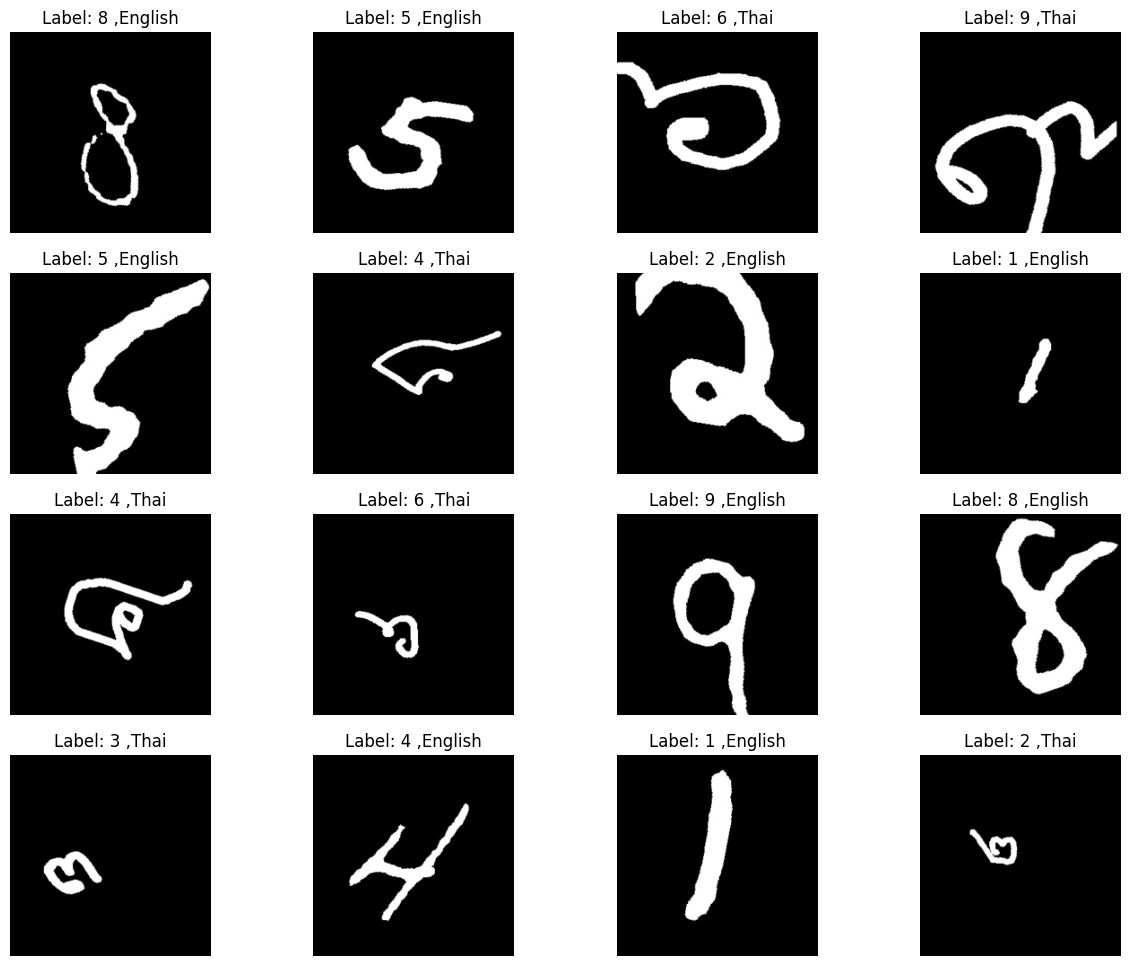

In [ ]:
### START CODE HERE ###
images, labels, languages = next(iter(train_loader))
fig, axes = plt.subplots(4, 4, figsize=(15, 12))
axes = axes.flatten()
language_lable = ["English", "Thai"]
for idx, (img, label, languages,
          ax) in enumerate(zip(images, labels, languages, axes)):

  image = img.numpy().transpose((1, 2, 0))

  ax.imshow(image, cmap='gray')
  ax.axis('off')
  ax.set_title(f"Label: {label} ,{language_lable[languages]}")
### END CODE HERE ###

# **Model Architechture**

In [ ]:
### START CODE HERE ###
class customVGG16(nn.Module):

 def __init__(self,
             add_feat_dims=None,
             h_dims=[1024,512,256],
             input_size=(3, 224, 224),
             usable_features=None,
             usable_denses=None):
  super(customVGG16, self).__init__()

  self.vgg16 = models.vgg16(pretrained=models.VGG16_Weights.DEFAULT)
  self.vgg16.flatten = nn.Flatten()

  for param in self.vgg16.features.parameters():
    param.requires_grad = True

  for param in self.vgg16.classifier.parameters():
    param.requires_grad = True

  if usable_features is not None:
    for idx in usable_features:
      for param in self.vgg16.features[idx].parameters():
        param.requires_grad = True

  if h_dims is not None:
    classifier = []
    in_features = self._get_input_size_fc(input_size, usable_features)

    for i, hdim in enumerate(h_dims):
      classifier.append(nn.Linear(in_features, hdim))
      classifier.append(nn.ReLU(inplace=True))
      classifier.append(nn.Dropout(p=0.5))
      in_features = hdim
    self.vgg16.classifier = nn.Sequential(*classifier)
  else:
    in_features = 1000

  self.classification_head = nn.Linear(in_features, 10)
  self.language_classification_head = nn.Linear(in_features, 1)

 def _get_input_size_fc(self,
                       input_shape,
                       usable_features=None,
                       flatten=False):
  with torch.no_grad():
    dummy_input = torch.zeros(1, *input_shape)
    x = self.vgg16.features(dummy_input)
    x = self.vgg16.flatten(x)
    return x.shape[-1]

 def forward(self, x):
  x = self.vgg16.features(x)
  x = self.vgg16.avgpool(x)
  x = self.vgg16.flatten(x)
  x = self.vgg16.classifier(x)

  class_output, lang_output = (self.classification_head(x),
                               self.language_classification_head(x))

  return F.log_softmax(class_output, dim=1), F.sigmoid(lang_output)
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
dummy_input = torch.zeros(32, *(3,224,224))
model = customVGG16(h_dims=None , input_size=(3,224,224),usable_features = None)
### END CODE HERE ###

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
### START CODE HERE ###
class_output , lang_output = model(dummy_input)
class_output.shape, lang_output.shape
### END CODE HERE ###

(torch.Size([32, 10]), torch.Size([32, 1]))

# **Train**

In [ ]:
### START CODE HERE ###
best_accuracy = 0.0
def train(model,
          optimizer,
          train_loader,
          test_loader,
          epochs=10,
          writer=None,
          checkpoint_path=None,
          device='cpu'):
  global best_accuracy
  model = model.to(device)

  print("🤖Training on", device)

  for epoch in range(epochs):
    model.train()

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    l1_lambda = 1e-5

    bce_loss = nn.BCELoss()

    train_bar = tqdm(train_loader,
                     desc=f'🚀Training Epoch [{epoch+1}/{epochs}]',
                     unit='batch')

    for batch_idx, (data, target, language) in enumerate(train_bar):
      data, target = data.to(device), target.to(device)
      language = language.float().view(-1, 1).to(device)

      optimizer.zero_grad()

      class_output, lang_output = model(data)
      loss_class = F.nll_loss(class_output, target)
      loss_lang = bce_loss(lang_output, language)

      l1_lambda = 1e-5
      l1_norm = sum(p.abs().sum() for p in model.parameters())
      loss = 0.9 * loss_class + 0.1 * loss_lang

      loss.backward()
      optimizer.step()

      train_bar.set_postfix(loss=loss.item())

    model.eval()

    scheduler.step()

    correct = 0
    language_correct = 0
    test_loss = 0
    test_lang_loss = 0

    all_preds = []
    all_targets = []
    all_lang_preds = []
    all_lang_targets = []

    with torch.no_grad():
      test_bar = tqdm(test_loader,
                      desc=f" Testing Epoch [{epoch+1}/{epochs}]",
                      unit='batch')

      for data, target, language in test_bar:
        data, target, language = data.to(device), target.to(
            device), language.to(device)
        class_output, lang_output = model(data)

        test_loss += F.nll_loss(class_output, target, reduction='sum').item()
        pred = class_output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

        test_lang_loss += bce_loss(lang_output, language.float().view(-1, 1))

        language_pred = lang_output.round()
        language_correct += language_pred.eq(
            language.view_as(language_pred)).sum().item()

        all_lang_preds.extend(language_pred.cpu().numpy())
        all_lang_targets.extend(language.cpu().numpy())

      test_loss /= len(test_loader.dataset)
      test_lang_loss /= len(test_loader.dataset)

      accuracy = 100. * correct / len(test_loader.dataset)
      language_accuracy = 100. * language_correct / len(test_loader.dataset)

      class_f1 = f1_score(all_targets, all_preds, average='weighted')
      language_f1 = f1_score(all_lang_targets,
                             all_lang_preds,
                             average='weighted')

      print(
          'Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\nAverage BCE loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\nF1 Score (Class): {:.4f}\nF1 Score (Language): {:.4f}\n👽Real Score: {:.4f}'
          .format(test_loss, correct, len(test_loader.dataset),
                  accuracy, test_lang_loss, language_correct,
                  len(test_loader.dataset), language_accuracy, class_f1,
                  language_f1, class_f1 * 0.9 + language_f1 * 0.1))

      Realscore = class_f1 * 0.9 + language_f1 * 0.1
      if Realscore > best_accuracy:
        best_accuracy = Realscore
        torch.save(model.state_dict(), checkpoint_path)
        print(
            f' # 🧠Best model saved with accuracy: {accuracy:.2f}% at epoch {epoch+1}🧠'
        )
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
model = customVGG16(h_dims=[1024,512,256])
opt = torch.optim.AdamW(model.parameters(), lr=0.0000875, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=opt, T_max=50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(model=model,
      optimizer=opt,
      train_loader=train_loader,
      test_loader=test_loader,
      epochs=50,
      checkpoint_path="/content/check_score.pth",
      device=device)

print(f"😎Best Score is {best_accuracy}")
### END CODE HERE ###

🤖Training on cuda


 Testing Epoch [1/50]: 100%|██████████| 22/22 [00:05<00:00,  4.04batch/s]


Test set: Average loss: 1.3985, Accuracy: 422/699 (60%)
Average BCE loss: 0.0186, Accuracy: 536/699 (77%)
F1 Score (Class): 0.5752
F1 Score (Language): 0.7665
👽Real Score: 0.5943
 # 🧠Best model saved with accuracy: 60.37% at epoch 1🧠


 Testing Epoch [2/50]: 100%|██████████| 22/22 [00:05<00:00,  4.29batch/s]


Test set: Average loss: 0.4388, Accuracy: 594/699 (85%)
Average BCE loss: 0.0145, Accuracy: 574/699 (82%)
F1 Score (Class): 0.8509
F1 Score (Language): 0.8189
👽Real Score: 0.8477
 # 🧠Best model saved with accuracy: 84.98% at epoch 2🧠


 Testing Epoch [3/50]: 100%|██████████| 22/22 [00:05<00:00,  4.31batch/s]


Test set: Average loss: 0.2845, Accuracy: 635/699 (91%)
Average BCE loss: 0.0095, Accuracy: 664/699 (95%)
F1 Score (Class): 0.9089
F1 Score (Language): 0.9499
👽Real Score: 0.9130
 # 🧠Best model saved with accuracy: 90.84% at epoch 3🧠


 Testing Epoch [4/50]: 100%|██████████| 22/22 [00:05<00:00,  4.28batch/s]


Test set: Average loss: 0.1829, Accuracy: 659/699 (94%)
Average BCE loss: 0.0064, Accuracy: 690/699 (99%)
F1 Score (Class): 0.9428
F1 Score (Language): 0.9871
👽Real Score: 0.9472
 # 🧠Best model saved with accuracy: 94.28% at epoch 4🧠


 Testing Epoch [5/50]: 100%|██████████| 22/22 [00:05<00:00,  4.31batch/s]


Test set: Average loss: 0.1684, Accuracy: 659/699 (94%)
Average BCE loss: 0.0051, Accuracy: 679/699 (97%)
F1 Score (Class): 0.9425
F1 Score (Language): 0.9714
👽Real Score: 0.9454


 Testing Epoch [6/50]: 100%|██████████| 22/22 [00:05<00:00,  4.31batch/s]


Test set: Average loss: 0.1479, Accuracy: 671/699 (96%)
Average BCE loss: 0.0044, Accuracy: 686/699 (98%)
F1 Score (Class): 0.9598
F1 Score (Language): 0.9814
👽Real Score: 0.9619
 # 🧠Best model saved with accuracy: 95.99% at epoch 6🧠


 Testing Epoch [7/50]: 100%|██████████| 22/22 [00:05<00:00,  4.33batch/s]


Test set: Average loss: 0.3934, Accuracy: 624/699 (89%)
Average BCE loss: 0.0048, Accuracy: 674/699 (96%)
F1 Score (Class): 0.8918
F1 Score (Language): 0.9642
👽Real Score: 0.8990


 Testing Epoch [8/50]: 100%|██████████| 22/22 [00:05<00:00,  4.28batch/s]


Test set: Average loss: 0.1605, Accuracy: 659/699 (94%)
Average BCE loss: 0.0024, Accuracy: 697/699 (100%)
F1 Score (Class): 0.9429
F1 Score (Language): 0.9971
👽Real Score: 0.9483


 Testing Epoch [9/50]: 100%|██████████| 22/22 [00:05<00:00,  4.32batch/s]


Test set: Average loss: 0.0968, Accuracy: 675/699 (97%)
Average BCE loss: 0.0024, Accuracy: 690/699 (99%)
F1 Score (Class): 0.9657
F1 Score (Language): 0.9871
👽Real Score: 0.9678
 # 🧠Best model saved with accuracy: 96.57% at epoch 9🧠


 Testing Epoch [10/50]: 100%|██████████| 22/22 [00:05<00:00,  4.32batch/s]


Test set: Average loss: 0.1304, Accuracy: 676/699 (97%)
Average BCE loss: 0.0019, Accuracy: 692/699 (99%)
F1 Score (Class): 0.9669
F1 Score (Language): 0.9900
👽Real Score: 0.9692
 # 🧠Best model saved with accuracy: 96.71% at epoch 10🧠


 Testing Epoch [11/50]: 100%|██████████| 22/22 [00:05<00:00,  4.37batch/s]


Test set: Average loss: 0.1269, Accuracy: 673/699 (96%)
Average BCE loss: 0.0015, Accuracy: 696/699 (100%)
F1 Score (Class): 0.9628
F1 Score (Language): 0.9957
👽Real Score: 0.9661


 Testing Epoch [12/50]: 100%|██████████| 22/22 [00:05<00:00,  4.30batch/s]


Test set: Average loss: 0.1504, Accuracy: 672/699 (96%)
Average BCE loss: 0.0010, Accuracy: 694/699 (99%)
F1 Score (Class): 0.9613
F1 Score (Language): 0.9928
👽Real Score: 0.9645


 Testing Epoch [13/50]: 100%|██████████| 22/22 [00:05<00:00,  4.33batch/s]


Test set: Average loss: 0.1289, Accuracy: 672/699 (96%)
Average BCE loss: 0.0015, Accuracy: 693/699 (99%)
F1 Score (Class): 0.9614
F1 Score (Language): 0.9914
👽Real Score: 0.9644


 Testing Epoch [14/50]: 100%|██████████| 22/22 [00:05<00:00,  4.30batch/s]


Test set: Average loss: 0.1441, Accuracy: 667/699 (95%)
Average BCE loss: 0.0017, Accuracy: 691/699 (99%)
F1 Score (Class): 0.9542
F1 Score (Language): 0.9886
👽Real Score: 0.9577


 Testing Epoch [15/50]: 100%|██████████| 22/22 [00:05<00:00,  4.32batch/s]


Test set: Average loss: 0.1501, Accuracy: 671/699 (96%)
Average BCE loss: 0.0012, Accuracy: 692/699 (99%)
F1 Score (Class): 0.9602
F1 Score (Language): 0.9900
👽Real Score: 0.9632


 Testing Epoch [16/50]: 100%|██████████| 22/22 [00:05<00:00,  4.31batch/s]


Test set: Average loss: 0.1140, Accuracy: 678/699 (97%)
Average BCE loss: 0.0012, Accuracy: 690/699 (99%)
F1 Score (Class): 0.9699
F1 Score (Language): 0.9871
👽Real Score: 0.9717
 # 🧠Best model saved with accuracy: 97.00% at epoch 16🧠


 Testing Epoch [17/50]: 100%|██████████| 22/22 [00:05<00:00,  4.33batch/s]


Test set: Average loss: 0.0957, Accuracy: 675/699 (97%)
Average BCE loss: 0.0011, Accuracy: 694/699 (99%)
F1 Score (Class): 0.9655
F1 Score (Language): 0.9928
👽Real Score: 0.9683


 Testing Epoch [18/50]: 100%|██████████| 22/22 [00:05<00:00,  4.28batch/s]


Test set: Average loss: 0.1254, Accuracy: 675/699 (97%)
Average BCE loss: 0.0010, Accuracy: 696/699 (100%)
F1 Score (Class): 0.9656
F1 Score (Language): 0.9957
👽Real Score: 0.9686


 Testing Epoch [19/50]: 100%|██████████| 22/22 [00:05<00:00,  4.31batch/s]


Test set: Average loss: 0.0991, Accuracy: 677/699 (97%)
Average BCE loss: 0.0010, Accuracy: 695/699 (99%)
F1 Score (Class): 0.9685
F1 Score (Language): 0.9943
👽Real Score: 0.9710


 Testing Epoch [20/50]: 100%|██████████| 22/22 [00:05<00:00,  4.33batch/s]


Test set: Average loss: 0.1057, Accuracy: 676/699 (97%)
Average BCE loss: 0.0007, Accuracy: 695/699 (99%)
F1 Score (Class): 0.9672
F1 Score (Language): 0.9943
👽Real Score: 0.9699


 Testing Epoch [21/50]: 100%|██████████| 22/22 [00:05<00:00,  4.30batch/s]


Test set: Average loss: 0.0825, Accuracy: 680/699 (97%)
Average BCE loss: 0.0006, Accuracy: 697/699 (100%)
F1 Score (Class): 0.9729
F1 Score (Language): 0.9971
👽Real Score: 0.9753
 # 🧠Best model saved with accuracy: 97.28% at epoch 21🧠


 Testing Epoch [22/50]: 100%|██████████| 22/22 [00:05<00:00,  4.35batch/s]


Test set: Average loss: 0.1232, Accuracy: 682/699 (98%)
Average BCE loss: 0.0008, Accuracy: 693/699 (99%)
F1 Score (Class): 0.9756
F1 Score (Language): 0.9914
👽Real Score: 0.9772
 # 🧠Best model saved with accuracy: 97.57% at epoch 22🧠


 Testing Epoch [23/50]: 100%|██████████| 22/22 [00:05<00:00,  4.35batch/s]


Test set: Average loss: 0.1123, Accuracy: 678/699 (97%)
Average BCE loss: 0.0009, Accuracy: 693/699 (99%)
F1 Score (Class): 0.9699
F1 Score (Language): 0.9914
👽Real Score: 0.9721


 Testing Epoch [24/50]: 100%|██████████| 22/22 [00:05<00:00,  4.28batch/s]


Test set: Average loss: 0.0990, Accuracy: 678/699 (97%)
Average BCE loss: 0.0007, Accuracy: 696/699 (100%)
F1 Score (Class): 0.9700
F1 Score (Language): 0.9957
👽Real Score: 0.9726


 Testing Epoch [25/50]: 100%|██████████| 22/22 [00:05<00:00,  4.29batch/s]


Test set: Average loss: 0.1128, Accuracy: 685/699 (98%)
Average BCE loss: 0.0006, Accuracy: 696/699 (100%)
F1 Score (Class): 0.9800
F1 Score (Language): 0.9957
👽Real Score: 0.9816
 # 🧠Best model saved with accuracy: 98.00% at epoch 25🧠


 Testing Epoch [26/50]: 100%|██████████| 22/22 [00:05<00:00,  4.19batch/s]


Test set: Average loss: 0.0730, Accuracy: 684/699 (98%)
Average BCE loss: 0.0006, Accuracy: 696/699 (100%)
F1 Score (Class): 0.9785
F1 Score (Language): 0.9957
👽Real Score: 0.9802


 Testing Epoch [27/50]: 100%|██████████| 22/22 [00:05<00:00,  4.19batch/s]


Test set: Average loss: 0.1478, Accuracy: 672/699 (96%)
Average BCE loss: 0.0005, Accuracy: 696/699 (100%)
F1 Score (Class): 0.9615
F1 Score (Language): 0.9957
👽Real Score: 0.9650


 Testing Epoch [28/50]: 100%|██████████| 22/22 [00:05<00:00,  4.15batch/s]


Test set: Average loss: 0.1156, Accuracy: 678/699 (97%)
Average BCE loss: 0.0012, Accuracy: 688/699 (98%)
F1 Score (Class): 0.9702
F1 Score (Language): 0.9843
👽Real Score: 0.9716


 Testing Epoch [29/50]: 100%|██████████| 22/22 [00:05<00:00,  4.21batch/s]


Test set: Average loss: 0.0883, Accuracy: 685/699 (98%)
Average BCE loss: 0.0004, Accuracy: 695/699 (99%)
F1 Score (Class): 0.9800
F1 Score (Language): 0.9943
👽Real Score: 0.9814


 Testing Epoch [30/50]: 100%|██████████| 22/22 [00:05<00:00,  4.15batch/s]


Test set: Average loss: 0.1278, Accuracy: 674/699 (96%)
Average BCE loss: 0.0007, Accuracy: 695/699 (99%)
F1 Score (Class): 0.9642
F1 Score (Language): 0.9943
👽Real Score: 0.9672


 Testing Epoch [31/50]: 100%|██████████| 22/22 [00:05<00:00,  4.23batch/s]


Test set: Average loss: 0.1236, Accuracy: 676/699 (97%)
Average BCE loss: 0.0022, Accuracy: 686/699 (98%)
F1 Score (Class): 0.9671
F1 Score (Language): 0.9814
👽Real Score: 0.9685


 Testing Epoch [32/50]: 100%|██████████| 22/22 [00:05<00:00,  4.19batch/s]


Test set: Average loss: 0.0955, Accuracy: 680/699 (97%)
Average BCE loss: 0.0010, Accuracy: 693/699 (99%)
F1 Score (Class): 0.9728
F1 Score (Language): 0.9914
👽Real Score: 0.9747


 Testing Epoch [33/50]: 100%|██████████| 22/22 [00:05<00:00,  4.24batch/s]


Test set: Average loss: 0.1346, Accuracy: 673/699 (96%)
Average BCE loss: 0.0005, Accuracy: 695/699 (99%)
F1 Score (Class): 0.9627
F1 Score (Language): 0.9943
👽Real Score: 0.9659


 Testing Epoch [34/50]: 100%|██████████| 22/22 [00:05<00:00,  4.20batch/s]


Test set: Average loss: 0.1504, Accuracy: 674/699 (96%)
Average BCE loss: 0.0004, Accuracy: 696/699 (100%)
F1 Score (Class): 0.9642
F1 Score (Language): 0.9957
👽Real Score: 0.9674


 Testing Epoch [35/50]: 100%|██████████| 22/22 [00:05<00:00,  4.21batch/s]


Test set: Average loss: 0.0961, Accuracy: 684/699 (98%)
Average BCE loss: 0.0004, Accuracy: 697/699 (100%)
F1 Score (Class): 0.9786
F1 Score (Language): 0.9971
👽Real Score: 0.9805


 Testing Epoch [36/50]: 100%|██████████| 22/22 [00:05<00:00,  4.24batch/s]


Test set: Average loss: 0.1107, Accuracy: 679/699 (97%)
Average BCE loss: 0.0004, Accuracy: 695/699 (99%)
F1 Score (Class): 0.9714
F1 Score (Language): 0.9943
👽Real Score: 0.9737


 Testing Epoch [37/50]: 100%|██████████| 22/22 [00:05<00:00,  4.22batch/s]


Test set: Average loss: 0.1616, Accuracy: 668/699 (96%)
Average BCE loss: 0.0010, Accuracy: 695/699 (99%)
F1 Score (Class): 0.9551
F1 Score (Language): 0.9943
👽Real Score: 0.9590


 Testing Epoch [38/50]: 100%|██████████| 22/22 [00:05<00:00,  4.24batch/s]


Test set: Average loss: 0.0948, Accuracy: 682/699 (98%)
Average BCE loss: 0.0005, Accuracy: 697/699 (100%)
F1 Score (Class): 0.9757
F1 Score (Language): 0.9971
👽Real Score: 0.9779


 Testing Epoch [39/50]: 100%|██████████| 22/22 [00:05<00:00,  4.10batch/s]


Test set: Average loss: 0.1008, Accuracy: 678/699 (97%)
Average BCE loss: 0.0007, Accuracy: 693/699 (99%)
F1 Score (Class): 0.9699
F1 Score (Language): 0.9914
👽Real Score: 0.9721


 Testing Epoch [40/50]: 100%|██████████| 22/22 [00:05<00:00,  4.09batch/s]


Test set: Average loss: 0.1426, Accuracy: 672/699 (96%)
Average BCE loss: 0.0009, Accuracy: 692/699 (99%)
F1 Score (Class): 0.9615
F1 Score (Language): 0.9900
👽Real Score: 0.9643


 Testing Epoch [41/50]: 100%|██████████| 22/22 [00:05<00:00,  4.07batch/s]


Test set: Average loss: 0.0875, Accuracy: 685/699 (98%)
Average BCE loss: 0.0004, Accuracy: 698/699 (100%)
F1 Score (Class): 0.9800
F1 Score (Language): 0.9986
👽Real Score: 0.9819
 # 🧠Best model saved with accuracy: 98.00% at epoch 41🧠


 Testing Epoch [42/50]: 100%|██████████| 22/22 [00:05<00:00,  3.92batch/s]


Test set: Average loss: 0.0961, Accuracy: 681/699 (97%)
Average BCE loss: 0.0005, Accuracy: 695/699 (99%)
F1 Score (Class): 0.9742
F1 Score (Language): 0.9943
👽Real Score: 0.9762


 Testing Epoch [43/50]: 100%|██████████| 22/22 [00:07<00:00,  2.77batch/s]


Test set: Average loss: 0.0934, Accuracy: 683/699 (98%)
Average BCE loss: 0.0007, Accuracy: 694/699 (99%)
F1 Score (Class): 0.9771
F1 Score (Language): 0.9928
👽Real Score: 0.9787


 Testing Epoch [44/50]: 100%|██████████| 22/22 [00:05<00:00,  3.85batch/s]


Test set: Average loss: 0.1013, Accuracy: 673/699 (96%)
Average BCE loss: 0.0004, Accuracy: 698/699 (100%)
F1 Score (Class): 0.9628
F1 Score (Language): 0.9986
👽Real Score: 0.9664


 Testing Epoch [45/50]: 100%|██████████| 22/22 [00:05<00:00,  3.91batch/s]


Test set: Average loss: 0.0644, Accuracy: 682/699 (98%)
Average BCE loss: 0.0007, Accuracy: 694/699 (99%)
F1 Score (Class): 0.9757
F1 Score (Language): 0.9928
👽Real Score: 0.9774


 Testing Epoch [46/50]: 100%|██████████| 22/22 [00:05<00:00,  3.84batch/s]


Test set: Average loss: 0.0627, Accuracy: 683/699 (98%)
Average BCE loss: 0.0007, Accuracy: 694/699 (99%)
F1 Score (Class): 0.9771
F1 Score (Language): 0.9928
👽Real Score: 0.9786


 Testing Epoch [47/50]: 100%|██████████| 22/22 [00:05<00:00,  3.87batch/s]


Test set: Average loss: 0.1074, Accuracy: 679/699 (97%)
Average BCE loss: 0.0008, Accuracy: 692/699 (99%)
F1 Score (Class): 0.9713
F1 Score (Language): 0.9900
👽Real Score: 0.9732


 Testing Epoch [48/50]: 100%|██████████| 22/22 [00:05<00:00,  3.95batch/s]


Test set: Average loss: 0.0843, Accuracy: 684/699 (98%)
Average BCE loss: 0.0002, Accuracy: 699/699 (100%)
F1 Score (Class): 0.9786
F1 Score (Language): 1.0000
👽Real Score: 0.9807


 Testing Epoch [49/50]: 100%|██████████| 22/22 [00:05<00:00,  3.88batch/s]


Test set: Average loss: 0.0724, Accuracy: 683/699 (98%)
Average BCE loss: 0.0004, Accuracy: 696/699 (100%)
F1 Score (Class): 0.9771
F1 Score (Language): 0.9957
👽Real Score: 0.9789


 Testing Epoch [50/50]: 100%|██████████| 22/22 [00:05<00:00,  3.92batch/s]

Test set: Average loss: 0.0957, Accuracy: 684/699 (98%)
Average BCE loss: 0.0007, Accuracy: 696/699 (100%)
F1 Score (Class): 0.9786
F1 Score (Language): 0.9957
👽Real Score: 0.9803
😎Best Score is 0.9818827054857873


In [ ]:
### START CODE HERE ###
class FeatureExtractor(nn.Module):

  def __init__(self, model, target_layers):
    super(FeatureExtractor, self).__init__()
    self.model = model
    self.target_layers = target_layers
    self.features = []

    for layer_name, layer in self.model.named_modules():
      if layer_name in target_layers:
        print(layer_name)
        layer.register_forward_hook(self.save_feature(layer_name))

  def save_feature(self, layer_name):

    def hook(module, input, output):
      self.features.append(output.clone())

    return hook

  def forward(self, x):
    self.features = []
    self.model(x)
    return self.features
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
targets = [name for name,_ in model.named_modules() if 'features.' in name]
targets
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
def visualize_feature_map(x, base_filename):
  out_dir = 'feature_map_result'
  os.makedirs(out_dir, exist_ok=True)
  x_channel_last = x[0].permute(1, 2, 0).cpu()

  num_channels = x_channel_last.size(2)

  num_rows = int(num_channels**0.5)
  num_cols = (num_channels // num_rows) + int(num_channels % num_rows > 0)

  fig, axes = plt.subplots(num_rows,
                           num_cols,
                           figsize=(8, 8),
                           subplot_kw={
                               'xticks': [],
                               'yticks': []
                           })
  for channel in range(num_channels):
    row = channel // num_cols
    col = channel % num_cols
    feat_m = x_channel_last[:, :, channel].detach().numpy()
    axes[row, col].imshow(feat_m, cmap='gray')
    axes[row, col].set_title(
        f'ch {channel + 1}\nrange: {feat_m.min(),feat_m.max()}', fontsize=7)

  base_filename = base_filename
  filename = f"{base_filename}.png"

  count = 1
  while os.path.exists(os.path.join(out_dir, filename)):
    filename = f"{base_filename}_{count}.png"
    count += 1
  fig.suptitle(filename.split('.')[0].split('/')[-1], fontsize=16)
  plt.tight_layout()
  plt.show()
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
model
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
feature_extractor = FeatureExtractor(model=model, target_layers=targets)
images, labels,languages = next(iter(train_loader))
images.shape
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
input_data = images[0].unsqueeze(0).to(device)
input_data.shape
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
input_data[0].shape
plt.imshow(input_data[0].cpu().numpy().transpose(1, 2, 0))
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
extracted_features = feature_extractor(input_data)

for idx, feature in enumerate(extracted_features):
    print(f"Feature from layer {targets[idx]}: {feature.shape}")
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
conv_output = extracted_features[8].squeeze(0) # vgg16.features.7
conv_output.shape
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
num_channels = conv_output.shape[0]
num_cols = 8
num_rows = (num_channels + num_cols - 1) // num_cols

num_channels, num_cols, num_rows
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
axes = axes.flatten()  # Flatten to easily iterate through

for i in range(num_channels):
    ax = axes[i]
    channel_data = conv_output[i].detach().cpu().numpy()
    # print(np.unique(channel_data))

    ax.imshow(channel_data, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Ch {i}')

# Hide any remaining subplots if there are any
for i in range(num_channels, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()
### END CODE HERE ###

# **Eval**

In [ ]:
### START CODE HERE ###
model.load_state_dict(torch.load("/content/check_score.pth"))
### END CODE HERE ###

<All keys matched successfully>

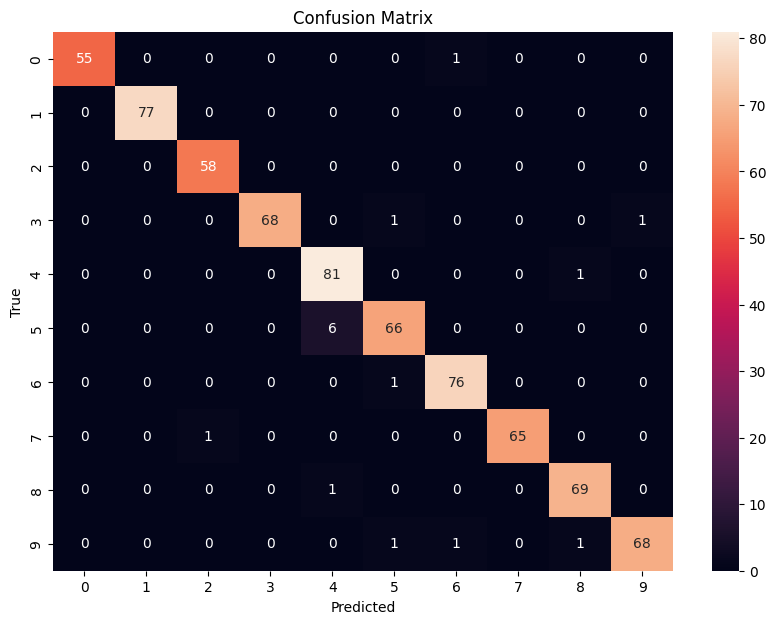

In [ ]:
### START CODE HERE ###
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
  for data, target, _ in test_loader:
    data, target = data.to(device), target.to(device)
    output, _ = model(data)
    pred = output.argmax(dim=1, keepdim=True)
    all_preds.extend(pred.cpu().numpy())
    all_targets.extend(target.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
report = classification_report(all_targets, all_preds)
print(report)
### END CODE HERE ###

# **Submission**



In [ ]:
###################################################
############## Exercise Submission ################
###################################################
base_dir = '/content/test/submission'
file_names, class_preds, lang_preds = [], [], []

model.eval()
with torch.no_grad():
    submit_bar = tqdm(range(0, 350), desc=f'📄 submit_dataset', unit='batch')
    submit_transform = transforms.Compose([
                        transforms.Grayscale(),
                        ReverseIntensity(threshold=100),
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Lambda(lambda x : torch.cat([x,x,x],0))
    ])

    for idx in submit_bar:

        file_name = f'image_{idx}.png'
        file_names.append(file_name)

        img_path = os.path.join(base_dir, file_name)

        image = Image.open(img_path).convert('RGB')
        image = submit_transform(image)
        image = image.unsqueeze(0).to(device)

        class_output, lang_output = model(image)

        class_pred = class_output.argmax(dim=1, keepdim=True)
        class_preds.extend(class_pred.cpu().numpy().flatten())

        lang_pred = lang_output.round()
        lang_preds.extend(lang_pred.cpu().numpy().flatten().astype('uint8'))

data = list(zip(file_names, lang_preds, class_preds))
submission_df = pd.DataFrame(data, columns=['file_name', 'language', 'value'])

output_path = '/content/ExerciseSubmission.csv'
submission_df.to_csv(output_path, index=False)

print(f"CSV file saved to {output_path}")
###################################################
############## Exercise Submission ################
###################################################

📄 submit_dataset: 100%|██████████| 350/350 [00:03<00:00, 91.22batch/s]

CSV file saved to /content/ExerciseSubmission.csv


In [ ]:
### START CODE HERE ###
submission_df
### END CODE HERE ###

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from PIL import Image
import os

from torch.utils.data import DataLoader, Dataset, Subset, random_split
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix
import seaborn as sns

model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

!curl -L -o test.zip https://raw.githubusercontent.com/shokku14/flies/main/test.zip
!unzip -o test.zip
!curl -L -o data.zip https://raw.githubusercontent.com/shokku14/flies/main/data.zip
!unzip -o data.zip

--

class ReverseIntensity:
    # ฟังก์ชันนี้เป็นการสร้างคลาสที่ใช้ในการกลับทิศทางความเข้มของภาพตามค่าความเข้มเฉลี่ยที่ตั้งไว้

    def __init__(self, threshold=150):
        # ฟังก์ชันเริ่มต้นสำหรับคลาส ReverseIntensity โดยรับค่า threshold (ค่าความเข้มที่ใช้ตัดสินใจ)
        # ค่าเริ่มต้นของ threshold ตั้งไว้ที่ 150
        self.threshold = threshold

    def __call__(self, image):
        # ฟังก์ชันนี้จะถูกเรียกเมื่อใช้ instance ของคลาสนี้ในการประมวลผลภาพ
        # ฟังก์ชันจะรับ input เป็นภาพซึ่งสามารถเป็นได้ทั้ง PIL Image หรือ numpy array

        if isinstance(image, Image.Image):
            # ตรวจสอบว่าภาพเป็นประเภท PIL Image หรือไม่
            image_np = np.array(image)
            # ถ้าใช่, แปลงภาพจาก PIL Image เป็น numpy array เพื่อให้ง่ายต่อการคำนวณ
        elif isinstance(image, np.ndarray):
            # ถ้าภาพเป็น numpy array อยู่แล้ว
            image_np = image
            # กำหนด image_np ให้เป็นภาพที่ส่งเข้ามาโดยไม่ต้องแปลง
        else:
            # ถ้าภาพไม่ได้อยู่ในประเภทที่รองรับ
            raise TypeError(
                "Unsupported type. Expected PIL Image or numpy array.")
            # ส่ง error ประเภท TypeError พร้อมข้อความแจ้งเตือนว่าไม่รองรับประเภทของภาพนี้

        if np.mean(image_np) > self.threshold:
            # คำนวณค่าความเข้มเฉลี่ยของภาพ (mean intensity)
            # และตรวจสอบว่าค่าความเข้มเฉลี่ยมากกว่า threshold หรือไม่
            reversed_image = 255 - image_np
            # ถ้ามากกว่า, ทำการกลับทิศทางความเข้มของภาพ (เช่น เปลี่ยนจากขาวเป็นดำ)
            return Image.fromarray(reversed_image)
            # แปลง numpy array กลับเป็น PIL Image แล้วส่งภาพที่กลับความเข้มแล้วกลับไป
        else:
            return image
            # ถ้าค่าความเข้มเฉลี่ยไม่มากกว่า threshold, ส่งภาพเดิมกลับไปโดยไม่ทำการเปลี่ยนแปลง

--

class MultiLanguageHandwrittenDataset(Dataset):
    # คลาสนี้สร้าง Dataset สำหรับภาพลายมือที่รองรับหลายภาษา โดยจะกำหนดภาพ, ป้ายกำกับ (label) และภาษาที่เกี่ยวข้อง

    def __init__(self, root_dirs, languages, transforms=None):
        # ฟังก์ชันเริ่มต้น (constructor) ที่ใช้กำหนด root_dirs (ตำแหน่งของโฟลเดอร์ที่เก็บข้อมูล),
        # languages (รายการของภาษาที่เกี่ยวข้องกับโฟลเดอร์นั้น ๆ) และ transforms (การแปลงภาพเพิ่มเติมที่อาจมี)
        self.root_dirs = root_dirs
        # กำหนด root_dirs ซึ่งเป็นรายการของโฟลเดอร์ที่เก็บภาพแต่ละภาษา
        self.languages = languages
        # กำหนด languages ซึ่งเป็นรายการของภาษาที่เชื่อมโยงกับโฟลเดอร์เหล่านั้น
        self.transform = transforms
        # กำหนด transforms ซึ่งเป็นการแปลงภาพที่อาจใช้ (เช่น การเพิ่มการบิดเบี้ยวของภาพ)
        self.samples = []
        # สร้างรายการว่างเปล่าสำหรับเก็บตัวอย่างภาพทั้งหมด (รวมถึงเส้นทางภาพ, ป้ายกำกับ, และภาษา)

        for root_dir, language in zip(self.root_dirs, self.languages):
            # ลูปผ่านแต่ละโฟลเดอร์ใน root_dirs และภาษาใน languages แบบจับคู่กัน
            for subdir in os.scandir(root_dir):
                # สแกนไดเรกทอรีหลักแต่ละอันใน root_dir และวนผ่านแต่ละ subdir
                if subdir.is_dir():
                    # ตรวจสอบว่ารายการย่อยเป็นโฟลเดอร์ (directory) หรือไม่
                    label = int(subdir.name)
                    # ใช้ชื่อของโฟลเดอร์ย่อยเป็นป้ายกำกับ (label) และแปลงชื่อโฟลเดอร์เป็นตัวเลข
                    for file in os.scandir(subdir.path):
                        # สแกนโฟลเดอร์ย่อยและวนผ่านแต่ละไฟล์ในโฟลเดอร์นั้น
                        if file.is_file():
                            # ตรวจสอบว่าไฟล์ที่พบเป็นไฟล์จริง ๆ หรือไม่
                            self.samples.append((file.path, label, language))
                            # เพิ่มข้อมูลเส้นทางไฟล์ (file path), ป้ายกำกับ (label), และภาษาที่เกี่ยวข้อง (language)
                            # ไปยังรายการ samples

    def __len__(self):
        # ฟังก์ชันที่ใช้คืนค่าความยาวของ dataset (จำนวนตัวอย่างทั้งหมด)
        return len(self.samples)
        # คืนค่าจำนวนตัวอย่างที่เก็บใน self.samples

    def __getitem__(self, idx):
        # ฟังก์ชันนี้จะถูกเรียกเมื่อดึงตัวอย่างจาก dataset ตามดัชนี (index)

        if torch.is_tensor(idx):
            # ตรวจสอบว่าดัชนี (index) เป็น tensor หรือไม่ (เช่นในกรณีที่มีการใช้งานกับ PyTorch DataLoader)
            idx = idx.tolist()
            # ถ้าใช่, แปลง tensor เป็นรายการ (list) หรือเลขปกติ

        img_path, label, language = self.samples[idx]
        # ดึงเส้นทางของภาพ, ป้ายกำกับ, และภาษาที่เกี่ยวข้องจาก self.samples ตามดัชนีที่กำหนด

        image = Image.open(img_path).convert('RGB')
        # เปิดภาพจากเส้นทางที่ได้มา และแปลงภาพให้เป็นโหมดสี RGB (3 channels: Red, Green, Blue)

        if self.transform:
            # ตรวจสอบว่ามีการแปลงภาพ (transform) ที่กำหนดไว้หรือไม่
            image = self.transform(image)
            # ถ้ามี, ใช้การแปลงภาพที่กำหนดไว้กับภาพ

        return image, label, language
        # ส่งภาพที่ผ่านการแปลง (หรือภาพต้นฉบับ), ป้ายกำกับ, และภาษาที่เกี่ยวข้องกลับไปยังผู้เรียกใช้

--

root_dirs = [
    "/content/data/data/data/eng-handwritten-dataset",
    "/content/data/data/data/thai-handwritten-dataset"
]
# กำหนด root_dirs ซึ่งเป็นรายการของโฟลเดอร์ที่เก็บข้อมูลลายมือ โดยโฟลเดอร์แรกสำหรับภาษาอังกฤษ
# และโฟลเดอร์ที่สองสำหรับภาษาไทย

languages = [0, 1]
# กำหนดรายการของรหัสภาษา โดยใช้ 0 สำหรับภาษาอังกฤษ และ 1 สำหรับภาษาไทย

transform = transforms.Compose([
    # สร้าง pipeline ของการแปลงภาพหลายๆ อย่างด้วย transforms.Compose
    transforms.Grayscale(),
    # แปลงภาพให้เป็นโทนสีเทา (Grayscale)
    ReverseIntensity(threshold=100),
    # เรียกใช้คลาส ReverseIntensity เพื่อตรวจสอบและกลับทิศทางความเข้มของภาพหากค่าความเข้มเฉลี่ยมากกว่า 100
    transforms.RandomAffine(degrees=(-27.5,27.5),
                            translate=(0.05, 0.05),
                            scale=(0.4, 1.2),
                            shear=10),
    # ใช้การแปลงแบบ RandomAffine ซึ่งสุ่มหมุนภาพในช่วงองศา -27.5 ถึง 27.5 องศา
    # แปลงตำแหน่งภาพเล็กน้อยในช่วง 0.05 ของขนาดภาพ, ปรับขนาดภาพสุ่มในช่วง 0.4 ถึง 1.2 เท่าของขนาดเดิม
    # และบิดเบี้ยวภาพเล็กน้อยด้วย shear angle 10 องศา
    transforms.Pad(15, padding_mode='constant', fill=0),
    # เติมขอบภาพด้วยค่า 0 (สีดำ) หนา 15 พิกเซล โดยเติมแบบ constant
    transforms.RandomResizedCrop(size=224, scale=(0.746, 1.0)),
    # ครอบภาพแบบสุ่มและปรับขนาดภาพให้เป็น 224x224 พิกเซล โดยขนาดภาพจะถูกสุ่มในช่วง 74.6% ถึง 100% ของขนาดต้นฉบับ
    transforms.ToTensor(),
    # แปลงภาพให้เป็น tensor เพื่อให้สามารถใช้กับ PyTorch ได้
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
    # ใช้ Lambda function เพื่อทำซ้ำข้อมูล tensor 3 ครั้งในแกนช่อง (channel)
    # เพื่อให้ภาพ grayscale มี 3 channels (เหมือน RGB)
])

dataset = MultiLanguageHandwrittenDataset(root_dirs=root_dirs,
                                          languages=languages,
                                          transforms=transform)
# สร้างออบเจกต์ของคลาส MultiLanguageHandwrittenDataset โดยใช้ root_dirs ที่กำหนดไว้
# (ซึ่งเก็บภาพภาษาอังกฤษและไทย) languages (รหัสของภาษา) และการแปลงภาพที่กำหนดใน transform

--

def load_data(reverse=False, normalize=False, batch_size=32):
    # ฟังก์ชันนี้ใช้ในการโหลดและแบ่งข้อมูลสำหรับการฝึก (training) และทดสอบ (testing)
    # รับพารามิเตอร์ reverse (สำหรับการกลับทิศทางความเข้ม), normalize (สำหรับการทำให้ค่าคงที่)
    # และ batch_size (ขนาดของ batch) โดยมีค่าเริ่มต้นที่ 32

    root_dirs = [
        "/content/data/data/data/eng-handwritten-dataset",
        "/content/data/data/data/thai-handwritten-dataset"
    ]
    # กำหนด root_dirs ซึ่งเป็นรายการของโฟลเดอร์ที่เก็บข้อมูลลายมือ
    # โดยโฟลเดอร์แรกสำหรับภาษาอังกฤษ และโฟลเดอร์ที่สองสำหรับภาษาไทย

    languages = [0, 1]
    # กำหนดรายการของรหัสภาษา โดยใช้ 0 สำหรับภาษาอังกฤษ และ 1 สำหรับภาษาไทย

    transform = transforms.Compose([
        # สร้าง pipeline ของการแปลงภาพหลายๆ อย่างด้วย transforms.Compose
        transforms.Grayscale(),
        # แปลงภาพให้เป็นโทนสีเทา (Grayscale)
        ReverseIntensity(threshold=100),
        # เรียกใช้คลาส ReverseIntensity เพื่อตรวจสอบและกลับทิศทางความเข้มของภาพหากค่าความเข้มเฉลี่ยมากกว่า 100
        transforms.RandomAffine(degrees=(-27.5,27.5),
                                translate=(0.05, 0.05),
                                scale=(0.4, 1.2),
                                shear=10),
        # ใช้การแปลงแบบ RandomAffine ซึ่งสุ่มหมุนภาพในช่วงองศา -27.5 ถึง 27.5 องศา
        # แปลงตำแหน่งภาพเล็กน้อยในช่วง 0.05 ของขนาดภาพ, ปรับขนาดภาพสุ่มในช่วง 0.4 ถึง 1.2 เท่าของขนาดเดิม
        # และบิดเบี้ยวภาพเล็กน้อยด้วย shear angle 10 องศา
        transforms.Pad(15, padding_mode='constant', fill=0),
        # เติมขอบภาพด้วยค่า 0 (สีดำ) หนา 15 พิกเซล โดยเติมแบบ constant
        transforms.RandomResizedCrop(size=224, scale=(0.746, 1.0)),
        # ครอบภาพแบบสุ่มและปรับขนาดภาพให้เป็น 224x224 พิกเซล โดยขนาดภาพจะถูกสุ่มในช่วง 74.6% ถึง 100% ของขนาดต้นฉบับ
        transforms.ToTensor(),
        # แปลงภาพให้เป็น tensor เพื่อให้สามารถใช้กับ PyTorch ได้
        transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
        # ใช้ Lambda function เพื่อทำซ้ำข้อมูล tensor 3 ครั้งในแกนช่อง (channel)
        # เพื่อให้ภาพ grayscale มี 3 channels (เหมือน RGB)
    ])

--

    dataset = MultiLanguageHandwrittenDataset(
        root_dirs=root_dirs,
        languages=languages,
        transforms=transform
    )
    # สร้างออบเจกต์ของคลาส MultiLanguageHandwrittenDataset โดยใช้ root_dirs ที่กำหนดไว้
    # (ซึ่งเก็บภาพภาษาอังกฤษและไทย) languages (รหัสของภาษา) และการแปลงภาพที่กำหนดใน transform

    train_size = int(0.8 * len(dataset))
    # กำหนดขนาดของชุดข้อมูลฝึก (training) เป็น 80% ของชุดข้อมูลทั้งหมด
    test_size = len(dataset) - train_size
    # กำหนดขนาดของชุดข้อมูลทดสอบ (testing) เป็นส่วนที่เหลือ (20%) ของชุดข้อมูลทั้งหมด

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    # แบ่งชุดข้อมูลเป็นสองส่วน: ชุดฝึก (train_dataset) และชุดทดสอบ (test_dataset)
    # โดยใช้สัดส่วนที่กำหนดไว้

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # สร้าง DataLoader สำหรับชุดข้อมูลฝึก โดยใช้ batch_size ที่กำหนดไว้ และทำการ shuffle (สุ่มลำดับข้อมูล)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # สร้าง DataLoader สำหรับชุดข้อมูลทดสอบ โดยใช้ batch_size ที่กำหนดไว้ แต่ไม่ทำการ shuffle

    return train_loader, test_loader
    # คืนค่า DataLoader สำหรับชุดข้อมูลฝึกและทดสอบ

# เรียกใช้ฟังก์ชัน load_data และเก็บผลลัพธ์ใน train_loader และ test_loader
train_loader, test_loader = load_data()

--

def get_dataset_stats(loader):
    # ฟังก์ชันนี้ใช้ในการคำนวณสถิติของชุดข้อมูล เช่น จำนวนตัวอย่างและจำนวนตัวอย่างในแต่ละคลาส

    label_count = {}
    # สร้าง dictionary เพื่อเก็บจำนวนภาพในแต่ละคลาส
    total_samples = 0
    # ตัวแปรสำหรับเก็บจำนวนตัวอย่างทั้งหมดในชุดข้อมูล

    for images, lables, languages in loader:
        # วนลูปผ่านข้อมูลทั้งหมดใน DataLoader ที่ส่งเข้ามา (train_loader หรือ test_loader)
        total_samples += lables.size(0)
        # เพิ่มจำนวนตัวอย่างใน batch ปัจจุบันไปยังตัวแปร total_samples
        for lable in lables:
            # วนลูปผ่านแต่ละ label ใน batch
            if lable.item() in label_count:
                label_count[lable.item()] += 1
                # ถ้า label นี้มีอยู่ใน dictionary แล้ว ให้เพิ่มจำนวนครั้ง
            else:
                label_count[lable.item()] = 1
                # ถ้า label นี้ยังไม่มีอยู่ใน dictionary ให้ตั้งค่าเป็น 1

    return label_count, total_samples
    # คืนค่า dictionary ของจำนวนตัวอย่างในแต่ละคลาสและจำนวนตัวอย่างทั้งหมด

train_label_count, train_total_samples = get_dataset_stats(train_loader)
test_label_count, test_total_samples = get_dataset_stats(test_loader)
# เรียกใช้ฟังก์ชัน get_dataset_stats กับ train_loader และ test_loader
# เก็บผลลัพธ์ใน train_label_count, train_total_samples, test_label_count, และ test_total_samples

print("Train Dataset:")
# พิมพ์ข้อมูลของชุดข้อมูลฝึก (Train Dataset)
for label, count in train_label_count.items():
    print(f"\tNumber of images in class {label}: {count}")
    # พิมพ์จำนวนภาพในแต่ละคลาสในชุดข้อมูลฝึก
print(f"\tNumber of training samples: {train_total_samples}")
# พิมพ์จำนวนตัวอย่างทั้งหมดในชุดข้อมูลฝึก

print("Test Dataset:")
# พิมพ์ข้อมูลของชุดข้อมูลทดสอบ (Test Dataset)
for label, count in test_label_count.items():
    print(f"\tNumber of images in class {label}: {count}")
    # พิมพ์จำนวนภาพในแต่ละคลาสในชุดข้อมูลทดสอบ
print(f"\tNumber of testing samples: {test_total_samples}")
# พิมพ์จำนวนตัวอย่างทั้งหมดในชุดข้อมูลทดสอบ

images, labels, languages = next(iter(train_loader))
# ดึง batch แรกจาก train_loader และเก็บใน images, labels, และ languages

fig, axes = plt.subplots(4, 4, figsize=(15, 12))
# สร้างกริดของ subplot ขนาด 4x4 เพื่อแสดงภาพ 16 ภาพในแต่ละ batch และกำหนดขนาดรูปภาพ (figsize)
axes = axes.flatten()
# แปลง axes เป็นลิสต์เพื่อให้สามารถเข้าถึงแต่ละ subplot ได้ง่าย

language_lable = ["English", "Thai"]
# กำหนดรายชื่อภาษาที่เชื่อมโยงกับรหัสภาษา (0 สำหรับภาษาอังกฤษ, 1 สำหรับภาษาไทย)

for idx, (img, label, language, ax) in enumerate(zip(images, labels, languages, axes)):
    # วนลูปผ่านแต่ละภาพ, label, และ language พร้อมกัน และเชื่อมโยงกับ subplot แต่ละตัว
    image = img.numpy().transpose((1, 2, 0))
    # แปลง tensor ของภาพเป็น numpy array และสลับแกนเพื่อให้แสดงผลได้ถูกต้อง

    ax.imshow(image, cmap='gray')
    # แสดงภาพใน subplot โดยใช้ color map แบบ grayscale (gray)
    ax.axis('off')
    # ปิดการแสดงแกนของ subplot
    ax.set_title(f"Label: {label}, {language_lable[languages]}")
    # ตั้งชื่อ subplot โดยแสดง label ของภาพและภาษาที่เกี่ยวข้อง

--

class customVGG16(nn.Module):
    # กำหนดคลาส customVGG16 ซึ่งสืบทอดมาจาก nn.Module เพื่อสร้างโมเดลแบบกำหนดเองโดยใช้ VGG16

    def __init__(self,
                 add_feat_dims=None,
                 h_dims=[1024,512,256],
                 input_size=(3, 224, 224),
                 usable_features=None,
                 usable_denses=None):
        # ฟังก์ชัน constructor ใช้สำหรับกำหนดค่าเริ่มต้นให้กับคลาส
        super(customVGG16, self).__init__()
        # เรียกใช้งาน constructor ของ nn.Module

        self.vgg16 = models.vgg16(pretrained=models.VGG16_Weights.DEFAULT)
        # โหลดโมเดล VGG16 ที่ pretrained ด้วยค่า weight ที่ดีที่สุด

        self.vgg16.flatten = nn.Flatten()
        # เพิ่มชั้น Flatten หลังจากดึงคุณลักษณะจากโมเดล VGG16

        for param in self.vgg16.features.parameters():
            param.requires_grad = True
            # กำหนดให้ทุกพารามิเตอร์ในส่วน features ของ VGG16 สามารถถูกปรับค่าได้ในระหว่างการฝึก (trainable)

        for param in self.vgg16.classifier.parameters():
            param.requires_grad = True
            # กำหนดให้ทุกพารามิเตอร์ในส่วน classifier ของ VGG16 สามารถถูกปรับค่าได้ในระหว่างการฝึก

        if usable_features is not None:
            for idx in usable_features:
                for param in self.vgg16.features[idx].parameters():
                    param.requires_grad = True
            # หากกำหนด usable_features ให้พารามิเตอร์ใน layer ที่ระบุสามารถถูกปรับค่าได้

        if h_dims is not None:
            classifier = []
            in_features = self._get_input_size_fc(input_size, usable_features)
            # หากกำหนดค่า h_dims ใช้ขนาด input ของข้อมูลเพื่อคำนวณขนาด input ที่ถูกต้องสำหรับชั้น fully connected (fc)

            for i, hdim in enumerate(h_dims):
                classifier.append(nn.Linear(in_features, hdim))
                classifier.append(nn.ReLU(inplace=True))
                classifier.append(nn.Dropout(p=0.5))
                in_features = hdim
            # สร้าง classifier ใหม่ตามขนาดที่ระบุใน h_dims โดยเพิ่มชั้น Linear, ReLU, และ Dropout

            self.vgg16.classifier = nn.Sequential(*classifier)
            # กำหนด classifier ใหม่ให้กับโมเดล VGG16
        else:
            in_features = 1000
            # หากไม่ได้กำหนด h_dims ใช้ค่าเริ่มต้นของ VGG16 classifier

        self.classification_head = nn.Linear(in_features, 10)
        # สร้าง head สำหรับการจำแนกประเภท โดยมี output เป็น 10 คลาส

        self.language_classification_head = nn.Linear(in_features, 1)
        # สร้าง head สำหรับการจำแนกภาษาซึ่งมี output เป็น 1 ค่า (binary classification)

    def _get_input_size_fc(self,
                           input_shape,
                           usable_features=None,
                           flatten=False):
        # ฟังก์ชันนี้ใช้เพื่อคำนวณขนาด input สำหรับ fully connected layer
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            # สร้างข้อมูลทดสอบที่มีขนาดตาม input_shape ที่กำหนด (ใช้เพื่อจำลองการคำนวณ)

            x = self.vgg16.features(dummy_input)
            # ส่งข้อมูลทดสอบผ่านชั้น features ของ VGG16

            x = self.vgg16.flatten(x)
            # Flatten output จากชั้น features ของ VGG16

            return x.shape[-1]
            # คืนค่าขนาดของ output เพื่อใช้ในการกำหนดขนาด input ของ fully connected layer

    def forward(self, x):
        # ฟังก์ชัน forward กำหนดขั้นตอนการคำนวณระหว่างการส่งข้อมูลผ่านโมเดล (forward pass)

        x = self.vgg16.features(x)
        # ส่งข้อมูลผ่านชั้น features ของ VGG16

        x = self.vgg16.avgpool(x)
        # ส่งข้อมูลผ่านชั้น average pooling ของ VGG16

        x = self.vgg16.flatten(x)
        # Flatten ข้อมูลเพื่อเตรียมส่งผ่านชั้น classifier

        x = self.vgg16.classifier(x)
        # ส่งข้อมูลผ่านชั้น classifier ของ VGG16

        class_output, lang_output = (self.classification_head(x),
                                     self.language_classification_head(x))
        # ส่งข้อมูลผ่านชั้น head ของการจำแนกประเภทและการจำแนกภาษา

        return F.log_softmax(class_output, dim=1), F.sigmoid(lang_output)
        # คืนค่าผลลัพธ์จากการจำแนกประเภทและการจำแนกภาษา โดยใช้ softmax สำหรับการจำแนกประเภทและ sigmoid สำหรับการจำแนกภาษา

dummy_input = torch.zeros(32, *(3,224,224))
# สร้างข้อมูลทดสอบ (dummy input) ที่มีขนาด batch size 32 และขนาดภาพ 3x224x224

model = customVGG16(h_dims=None , input_size=(3,224,224), usable_features=None)
# สร้างโมเดล customVGG16 โดยกำหนดค่า h_dims เป็น None และ usable_features เป็น None

class_output, lang_output = model(dummy_input)
# ส่งข้อมูลทดสอบผ่านโมเดล และรับผลลัพธ์จากการจำแนกประเภทและการจำแนกภาษา

class_output.shape, lang_output.shape
# ตรวจสอบรูปทรงของผลลัพธ์จากการจำแนกประเภทและการจำแนกภาษา

--

# กำหนดค่าเริ่มต้นของตัวแปร best_accuracy เพื่อเก็บค่าความแม่นยำที่ดีที่สุด
best_accuracy = 0.0

# ฟังก์ชันสำหรับการเทรนและประเมินผลโมเดล
def train(model,
          optimizer,
          train_loader,
          test_loader,
          epochs=10,
          writer=None,
          checkpoint_path=None,
          device='cpu'):
    # ประกาศใช้ตัวแปร best_accuracy ในระดับ global เพื่อให้ใช้ในฟังก์ชันนี้ได้
    global best_accuracy

    # ส่งโมเดลไปที่อุปกรณ์ที่เลือก เช่น CPU หรือ GPU
    model = model.to(device)

    # แสดงข้อความว่ากำลังทำการฝึกโมเดลอยู่บนอุปกรณ์อะไร
    print("🤖Training on", device)

    # เริ่มการวนลูปการเทรนตามจำนวน epoch ที่กำหนด
    for epoch in range(epochs):
        # ตั้งโมเดลให้อยู่ในโหมด train (เปิดการเรียนรู้)
        model.train()

        # สร้างตัว scheduler สำหรับปรับค่า learning rate ตาม cosine annealing
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        # กำหนดค่า L1 regularization ที่จะนำมาใช้ลด overfitting
        l1_lambda = 1e-5

        # กำหนดการใช้ Binary Cross Entropy Loss สำหรับ language output
        bce_loss = nn.BCELoss()

        # สร้าง progress bar สำหรับแสดงสถานะการเทรนในแต่ละ batch
        train_bar = tqdm(train_loader,
                         desc=f'🚀Training Epoch [{epoch+1}/{epochs}]',
                         unit='batch')

        # วนลูปการเทรนตาม batch ใน train_loader
        for batch_idx, (data, target, language) in enumerate(train_bar):
            # ย้ายข้อมูล data, target, และ language ไปยังอุปกรณ์ที่เลือก (เช่น CPU หรือ GPU)
            data, target = data.to(device), target.to(device)
            language = language.float().view(-1, 1).to(device)

            # เคลียร์ gradient ของ optimizer ก่อนการ backward
            optimizer.zero_grad()

            # ส่งข้อมูลผ่านโมเดลและรับค่า output ของ class และ language
            class_output, lang_output = model(data)

            # คำนวณ cross entropy loss สำหรับ class output
            loss_class = F.nll_loss(class_output, target)

            # คำนวณ binary cross entropy loss สำหรับ language output
            loss_lang = bce_loss(lang_output, language)

            # คำนวณค่า L1 norm สำหรับ regularization
            l1_lambda = 1e-5
            l1_norm = sum(p.abs().sum() for p in model.parameters())

            # รวมค่า loss ของ class และ language โดยให้ class มีความสำคัญ 90% และ language 10%
            loss = 0.9 * loss_class + 0.1 * loss_lang

            # ทำการ backward propagation เพื่อหาค่า gradient
            loss.backward()

            # อัพเดทค่า parameter ของโมเดลตามค่า gradient ที่ได้
            optimizer.step()

            # อัพเดท progress bar ด้วยค่าการสูญเสีย (loss) ใน batch นั้น
            train_bar.set_postfix(loss=loss.item())

        # ตั้งโมเดลให้อยู่ในโหมดประเมินผล (evaluation)
        model.eval()

        # ปรับค่า learning rate ด้วย scheduler
        scheduler.step()

        # ตัวแปรสำหรับเก็บผลลัพธ์การทดสอบ
        correct = 0
        language_correct = 0
        test_loss = 0
        test_lang_loss = 0

        # ตัวแปรสำหรับเก็บผลลัพธ์ที่ใช้ในการคำนวณ F1 score
        all_preds = []
        all_targets = []
        all_lang_preds = []
        all_lang_targets = []

        # ปิด gradient computation ในช่วงทดสอบ (เพื่อประหยัดหน่วยความจำ)
        with torch.no_grad():
            # สร้าง progress bar สำหรับแสดงสถานะการทดสอบในแต่ละ batch
            test_bar = tqdm(test_loader,
                            desc=f" Testing Epoch [{epoch+1}/{epochs}]",
                            unit='batch')

            # วนลูปการทดสอบตาม batch ใน test_loader
            for data, target, language in test_bar:
                # ย้ายข้อมูล data, target, และ language ไปยังอุปกรณ์ที่เลือก
                data, target, language = data.to(device), target.to(device), language.to(device)

                # ส่งข้อมูลผ่านโมเดลและรับค่า output ของ class และ language
                class_output, lang_output = model(data)

                # คำนวณ test loss สำหรับ class output
                test_loss += F.nll_loss(class_output, target, reduction='sum').item()

                # หาผลลัพธ์การทำนายจาก class output (เลือก class ที่มีค่า log-probability สูงที่สุด)
                pred = class_output.argmax(dim=1, keepdim=True)

                # นับจำนวนการทำนายที่ถูกต้อง
                correct += pred.eq(target.view_as(pred)).sum().item()

                # เก็บผลลัพธ์การทำนายและ target เพื่อนำไปคำนวณ F1 score
                all_preds.extend(pred.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

                # คำนวณ binary cross entropy loss สำหรับ language output
                test_lang_loss += bce_loss(lang_output, language.float().view(-1, 1))

                # หาผลลัพธ์การทำนายของ language (round เพื่อให้เป็น 0 หรือ 1)
                language_pred = lang_output.round()

                # นับจำนวนการทำนายของ language ที่ถูกต้อง
                language_correct += language_pred.eq(language.view_as(language_pred)).sum().item()

                # เก็บผลลัพธ์การทำนายและ target ของ language เพื่อนำไปคำนวณ F1 score
                all_lang_preds.extend(language_pred.cpu().numpy())
                all_lang_targets.extend(language.cpu().numpy())

            # คำนวณค่าเฉลี่ยของ test loss สำหรับ class และ language
            test_loss /= len(test_loader.dataset)
            test_lang_loss /= len(test_loader.dataset)

            # คำนวณความแม่นยำของ class และ language
            accuracy = 100. * correct / len(test_loader.dataset)
            language_accuracy = 100. * language_correct / len(test_loader.dataset)

            # คำนวณค่า F1 score สำหรับ class และ language
            class_f1 = f1_score(all_targets, all_preds, average='weighted')
            language_f1 = f1_score(all_lang_targets, all_lang_preds, average='weighted')

            # แสดงผลลัพธ์การทดสอบ
            print(
                'Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\nAverage BCE loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\nF1 Score (Class): {:.4f}\nF1 Score (Language): {:.4f}\n👽Real Score: {:.4f}'
                .format(test_loss, correct, len(test_loader.dataset),
                        accuracy, test_lang_loss, language_correct,
                        len(test_loader.dataset), language_accuracy, class_f1,
                        language_f1, class_f1 * 0.9 + language_f1 * 0.1))

            # คำนวณค่า "Real Score" จาก class_f1 และ language_f1 โดยให้ class_f1 มีน้ำหนัก 90% และ language_f1 มีน้ำหนัก 10%
            Realscore = class_f1 * 0.9 + language_f1 * 0.1

            # ถ้า Real Score นี้ดีกว่าค่าที่ดีที่สุดก่อนหน้า ให้บันทึกโมเดลไว้
            if Realscore > best_accuracy:
                best_accuracy = Realscore
                torch.save(model.state_dict(), checkpoint_path)
                print(f' # 🧠Best model saved with accuracy: {accuracy:.2f}% at epoch {epoch+1}🧠')

--

# สร้างโมเดล customVGG16 โดยมี hidden dimensions (h_dims) กำหนดเป็น [1024, 512, 256]
model = customVGG16(h_dims=[1024,512,256])

# กำหนด optimizer เป็น AdamW พร้อม learning rate 0.0000875 และใช้ weight_decay 1e-4 เพื่อช่วยลดการ overfitting
opt = torch.optim.AdamW(model.parameters(), lr=0.0000875, weight_decay=1e-4)

# สร้าง scheduler ที่ใช้การปรับค่า learning rate ตาม cosine annealing โดย T_max กำหนดเป็น 50 ซึ่งหมายถึงจำนวนรอบ epoch
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=opt, T_max=50)

# ตรวจสอบว่า GPU สามารถใช้งานได้หรือไม่ หากใช้งานได้ให้ใช้ 'cuda' แต่ถ้าไม่สามารถใช้งานได้จะใช้ 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# เรียกใช้ฟังก์ชัน train เพื่อฝึกโมเดล โดยกำหนดค่า model, optimizer, train_loader, test_loader, จำนวน epochs,
# ตำแหน่งที่ต้องการบันทึก checkpoint ของโมเดล และอุปกรณ์ที่ใช้ (เช่น GPU หรือ CPU)
train(model=model,
      optimizer=opt,
      train_loader=train_loader,
      test_loader=test_loader,
      epochs=50,
      checkpoint_path="/content/check_score.pth",
      device=device)

# แสดงผลค่าความแม่นยำที่ดีที่สุด (best_accuracy) หลังจากทำการเทรนเสร็จ
print(f"😎Best Score is {best_accuracy}")

--

# โหลดพารามิเตอร์ของโมเดลจากไฟล์ที่บันทึกไว้
model.load_state_dict(torch.load("/content/check_score.pth"))

# กำหนดตำแหน่งของโฟลเดอร์ที่มีรูปภาพสำหรับการทดสอบ
base_dir = '/content/test/submission'

# สร้างลิสต์สำหรับเก็บชื่อไฟล์, ผลลัพธ์การทำนายของคลาส และผลลัพธ์การทำนายของภาษาสำหรับการส่งข้อมูล
file_names, class_preds, lang_preds = [], [], []

# ตั้งค่าโมเดลให้อยู่ในโหมดประเมินผล (evaluation mode)
model.eval()

# ปิดการคำนวณ gradient เพื่อลดการใช้หน่วยความจำและเพิ่มความเร็วในระหว่างการทดสอบ
with torch.no_grad():

    # สร้าง progress bar สำหรับการส่งข้อมูล โดยกำหนดให้วนลูป 350 ครั้ง (เนื่องจากมี 350 รูป)
    submit_bar = tqdm(range(0, 350), desc=f'📄 submit_dataset', unit='batch')

    # กำหนดการแปลงภาพ (transformations) สำหรับการเตรียมภาพก่อนนำเข้าระบบโมเดล
    submit_transform = transforms.Compose([
                        transforms.Grayscale(),  # แปลงภาพให้เป็นโทนสีเทา
                        ReverseIntensity(threshold=100),  # แปลงความเข้มของพิกเซลในภาพให้กลับด้าน (ตาม threshold ที่กำหนด)
                        transforms.Resize((224,224)),  # ปรับขนาดภาพเป็น 224x224 พิกเซล
                        transforms.ToTensor(),  # แปลงภาพให้เป็น Tensor
                        transforms.Lambda(lambda x : torch.cat([x,x,x],0))  # นำ Tensor ของภาพที่มี 1 channel มาทำให้เป็น 3 channels (RGB)
    ])

    # วนลูปผ่านภาพทุกไฟล์ในโฟลเดอร์ submission โดยใช้ progress bar แสดงสถานะ
    for idx in submit_bar:

        # สร้างชื่อไฟล์ตามลำดับ โดยใช้รูปแบบ image_{index}.png
        file_name = f'image_{idx}.png'
        file_names.append(file_name)  # เก็บชื่อไฟล์ไว้ในลิสต์ file_names

        # ระบุตำแหน่งของไฟล์รูปภาพ
        img_path = os.path.join(base_dir, file_name)

        # เปิดไฟล์รูปภาพแล้วแปลงเป็น RGB
        image = Image.open(img_path).convert('RGB')

        # แปลงภาพโดยใช้ transform ที่ได้กำหนดไว้ก่อนหน้านี้
        image = submit_transform(image)

        # เพิ่ม dimension ใหม่ให้กับภาพเพื่อให้เป็นรูปแบบที่โมเดลรับได้ (batch size = 1)
        image = image.unsqueeze(0).to(device)

        # ส่งข้อมูลภาพผ่านโมเดลเพื่อรับผลลัพธ์การทำนายสำหรับ class และ language
        class_output, lang_output = model(image)

        # หาผลลัพธ์การทำนายของ class โดยเลือกคลาสที่มีค่าสูงสุด (การทำนายแบบ argmax)
        class_pred = class_output.argmax(dim=1, keepdim=True)

        # เก็บผลลัพธ์การทำนายของคลาส (flatten เพื่อให้เป็น array) ไว้ในลิสต์ class_preds
        class_preds.extend(class_pred.cpu().numpy().flatten())

        # หาผลลัพธ์การทำนายของ language โดยใช้การปัดเศษ (round) เพื่อให้ได้ค่าเป็น 0 หรือ 1
        lang_pred = lang_output.round()

        # เก็บผลลัพธ์การทำนายของ language ไว้ในลิสต์ lang_preds โดยแปลงให้เป็น uint8
        lang_preds.extend(lang_pred.cpu().numpy().flatten().astype('uint8'))

# รวมข้อมูล file_names, lang_preds และ class_preds เข้าด้วยกันเป็น zip
data = list(zip(file_names, lang_preds, class_preds))

# สร้าง DataFrame จากข้อมูลที่ได้ โดยกำหนดคอลัมน์เป็น file_name, language, และ value
submission_df = pd.DataFrame(data, columns=['file_name', 'language', 'value'])

# กำหนดตำแหน่งไฟล์ CSV ที่จะบันทึก
output_path = '/content/ExerciseSubmission.csv'

# บันทึก DataFrame เป็นไฟล์ CSV โดยไม่ใส่ index
submission_df.to_csv(output_path, index=False)

# แสดงข้อความว่าไฟล์ CSV ได้ถูกบันทึกไว้ที่ตำแหน่งที่กำหนด
print(f"CSV file saved to {output_path}")

--

# โหลดพารามิเตอร์ของโมเดลจากไฟล์ที่บันทึกไว้ (state_dict) เพื่อใช้สำหรับการทดสอบ
model.load_state_dict(torch.load("/content/check_score.pth"))

# ตั้งโมเดลให้อยู่ในโหมดประเมินผล (evaluation mode) เพื่อปิดการทำงานของ dropout และ batch normalization
model.eval()

# สร้างลิสต์เพื่อเก็บค่าผลลัพธ์การทำนายและค่าเป้าหมายทั้งหมด
all_preds = []
all_targets = []

# ปิดการคำนวณ gradient เพื่อลดการใช้หน่วยความจำและเพิ่มความเร็วในการทดสอบ
with torch.no_grad():

  # วนลูปผ่านชุดข้อมูลทดสอบ (test_loader) เพื่อทำนายผลลัพธ์
  for data, target, _ in test_loader:

    # ส่งข้อมูลภาพและเป้าหมายไปยังอุปกรณ์ที่กำหนด (CPU หรือ GPU)
    data, target = data.to(device), target.to(device)

    # ทำการทำนายผลลัพธ์ผ่านโมเดล โดย output คือผลลัพธ์การทำนาย
    output, _ = model(data)

    # หาค่าผลลัพธ์ที่มีความน่าจะเป็นสูงสุด (argmax) สำหรับการทำนายคลาส
    pred = output.argmax(dim=1, keepdim=True)

    # เพิ่มผลลัพธ์การทำนายที่ได้ลงในลิสต์ all_preds (แปลงกลับมาเป็น numpy)
    all_preds.extend(pred.cpu().numpy())

    # เพิ่มค่าเป้าหมายที่แท้จริงลงในลิสต์ all_targets (แปลงกลับมาเป็น numpy)
    all_targets.extend(target.cpu().numpy())

# สร้าง confusion matrix โดยใช้ค่าผลลัพธ์การทำนาย (all_preds) และค่าเป้าหมายจริง (all_targets)
cm = confusion_matrix(all_targets, all_preds)

# สร้างกราฟ heatmap ของ confusion matrix ด้วยขนาด 10x7 เพื่อให้ดูชัดเจน
plt.figure(figsize=(10, 7))

# วาด heatmap ของ confusion matrix พร้อมแสดงค่าภายในแต่ละช่อง
sns.heatmap(cm, annot=True, fmt='d')

# กำหนดชื่อแกน x เป็น 'Predicted' (ผลลัพธ์ที่ทำนาย)
plt.xlabel('Predicted')

# กำหนดชื่อแกน y เป็น 'True' (ผลลัพธ์จริง)
plt.ylabel('True')

# กำหนดชื่อกราฟว่า 'Confusion Matrix'
plt.title('Confusion Matrix')

# แสดงกราฟ
plt.show()

# สร้างรายงานสถิติของการทำนาย เช่น precision, recall, f1-score โดยใช้ค่าเป้าหมายจริงและค่าผลลัพธ์การทำนาย
report = classification_report(all_targets, all_preds)

# พิมพ์รายงานออกมา
print(report)

